# Forecasting #

In [1]:
# imports
import pandas as pd
import numpy as np
import time

In [2]:
# define data location
location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
#location = '/Users/loki/Documents/Data/Forecasting Project/'

In [3]:
# load data
granularity = "daily"

if granularity == "daily":
    test = pd.read_pickle(location+'fcast_daily.pkl.zip') # 2 years of data
    train = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip') # most recent year, id/date sufficiency
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    codebook = pd.read_pickle(location+'codebook.pkl.zip')
elif granularity == "hourly":
    test = pd.read_pickle(location+'fcast_hourly.pkl.zip') # 2 years of data
    train = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip') # most recent year, id/date sufficiency
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    codebook = pd.read_pickle(location+'codebook.pkl.zip')
else:
    print("Granularity not in ('daily','hourly')")

In [4]:
# testing dates are the older year
test = test[test['Dt'] < "10-1-2017"]

## Forecast by Rate Code (TARIFF) ##

### Train ###

In [5]:
# calculate cluster centroids
data = train[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','TARIFF']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('TARIFF').mean().reset_index()

In [6]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='TARIFF',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [7]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

,TARIFF,Dt,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,GC0,2017-10-12,11.456768,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
1,GCE,2017-10-12,3.000000,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
2,GH0,2017-10-12,0.515451,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
3,GH5,2017-10-12,0.750000,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
4,GH8,2017-10-12,0.564103,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667


In [8]:
# Treat tariff as kmeans cluster
# Build regression model per tariff centroid
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

if granularity == 'daily':
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
elif granularity == 'hourly':
    features = ['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta',
                'MORN','DAY','EVE','NIGHT']

# save model and equation for each cluster
models = []
rTable = pd.DataFrame(index=(['intercept']+ features + ['MSE','R2']))

for code in centroids_clust['TARIFF'].unique():
    data = centroids_clust[(centroids_clust['TARIFF']==code)]
    X = data[data['TARIFF']==code][features]
    y = data[data['TARIFF']==code]['Use']
    
    # fit the regression model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    models.append((code,regr))
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[code] = [intercept]+list(chain(coefs))+[err]+[r2]
    del (data, X, y)

models = dict(models)
rTable = rTable.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [9]:
rTable

,intercept,LowDB1,LowDB1delta,MSE,R2
GC0,57.729361,-0.740053,-0.620261,23.563803,0.880534
GCE,39.994768,-0.563246,-0.420530,27.583522,0.784049
GH0,7.881034,-0.114155,-0.099194,0.585036,0.876201
GH5,8.112662,-0.112411,-0.100681,1.928803,0.675917
GH8,7.121975,-0.102078,-0.088407,0.484294,0.872371
GHC,39.555197,-0.565578,-0.478173,17.003883,0.856494
GHE,46.094075,-0.583824,-0.436822,12.173731,0.898365
GR0,6.463627,-0.093113,-0.078296,0.402355,0.872358
GR5,2.627284,-0.003022,-0.056342,4.821359,0.023505
GR8,7.430028,-0.105541,-0.091468,0.482275,0.880064


### Test ###

In [10]:
# calculate cluster centroids
data = test[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','TARIFF']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('TARIFF').mean().reset_index()

In [11]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='TARIFF',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [12]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather,
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

,TARIFF,Dt,Use,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,...,AvgHumid,Humid1,Humid1delta,AvgWind,Wind1,Wind1delta,AvgDaytimeCloud,AvgCloud,Cloud1,Cloud1delta
0,TFG,2016-10-01,243.39,61.125000,64,58,60.125000,1.000000,63.0,1.0,...,90.666667,91.041667,-0.375000,11.000000,15.208333,-4.208333,100.000000,100.000000,100.000000,0.000000
1,TFG,2016-10-02,223.09,63.458333,67,61,61.125000,2.333333,64.0,3.0,...,90.875000,90.666667,0.208333,5.500000,11.000000,-5.500000,95.000000,96.250000,100.000000,-3.750000
2,TFG,2016-10-03,174.88,67.208333,76,63,63.458333,3.750000,67.0,9.0,...,74.500000,90.875000,-16.375000,4.625000,5.500000,-0.875000,54.166667,62.500000,96.250000,-33.750000
3,TFG,2016-10-04,214.29,62.833333,68,59,67.208333,-4.375000,76.0,-8.0,...,79.291667,74.500000,4.791667,7.666667,4.625000,3.041667,90.000000,64.583333,62.500000,2.083333
4,TFG,2016-10-05,223.77,61.750000,71,56,62.833333,-1.083333,68.0,3.0,...,70.458333,79.291667,-8.833333,8.500000,7.666667,0.833333,27.500000,31.250000,64.583333,-33.333333


In [16]:
# For each tariff, forecast subsequent year of use
from sklearn import linear_model

from itertools import chain
from timeit import default_timer as timer

code_error = pd.DataFrame(columns=['Acts','Preds'])

for code in centroids_clust['TARIFF'].unique():
    data = centroids_clust[(centroids_clust['TARIFF']==code)]
    X = data[data['TARIFF']==code][features]
    y = data[data['TARIFF']==code]['Use']
    
    regr = models[code]
    yhat = regr.predict(X)
    
    err = pd.DataFrame({'Acts':y, 'Preds':yhat})
    code_error = code_error.append(err)
    del (data, X, y)

In [55]:
def errfn (acts, preds, method):
    """
    Calculates error using a variety of functions, 
    incl. Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), & Log Accuracy Ratio (LNQ)
    SMAPE is Symmetric Mean Average Percentage Error. Note: A limitation to SMAPE is that if the actual value or forecast value is 0, the value of error will boom up to the upper-limit of error.
    LnQ acts as an improved SMAPE metric when all values are positive.  See: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

    Parameters
    ----------
    acts : actual values (ground truth) in list or numpy array
    preds : predicted values  in list or numpy array
    method : error function, including RMSE, MAE, SMAPE, LnQ

    Returns
    ----------
    error : float

    @author: Yi Zhu, Alex Graber
    """

    # force method to uppercase
    method = method.upper()
    
    # check to ensure equal length vectors
    if (len(acts) != len(preds)):
        print("Abs and Preds do not have equivalent length!")
    
    # param detection
    if (method == "RMSE"): 
        #calculate RMSE
        from math import sqrt
        from sklearn.metrics import mean_squared_error
        error = sqrt(mean_squared_error(acts, preds))
    elif (method == "MAE"):
        #calculate MAE
        from sklearn.metrics import mean_absolute_error
        error = mean_absolute_error(acts, preds)
    elif (method == "SMAPE"):
        #calculate SMAPE
        numerator = abs(preds-acts)
        #denominator = (abs(acts) + abs(preds))/2
        denominator = (acts+preds)
        error = np.sum(numerator)/np.sum(denominator)
    elif (method == "LNQ"):
        #calculate LnQ
        error = np.sum(np.log(preds/acts)**2)
    else:
        print("Attempted method not in [RMSE, MAE, SMAPE,LNQ]")

    return error

In [18]:
code_error[code_error['Preds']<0]

,Acts,Preds
76,447.66,-3.728422
100,438.56,-37.929651
101,395.33,-53.847955


In [56]:
# calculate error
rmse = errfn(code_error['Acts'], code_error['Preds'], 'RMSE')
mae = errfn(code_error['Acts'], code_error['Preds'], 'MAE')
smape = errfn(code_error['Acts'], code_error['Preds'], 'SMAPE')
lnq = errfn(code_error['Acts'], code_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

RMSE:  242.30687506337244 
MAE:  206.87163829025732 
SMAPE:  0.34401986576642457 
LNQ:  303.2997424922339


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


## Forecast by Cluster ##

### Train ###

In [20]:
# calculate cluster centroids
data = train[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('Cluster').mean().reset_index()

In [21]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [22]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

,Cluster,Dt,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,H_H,2017-10-12,5.095840,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
1,H_L,2017-10-12,839.411429,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
2,H_M,2017-10-12,173.560833,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
3,L_H,2017-10-12,0.498770,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
4,L_L,2017-10-12,1.093333,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667


In [23]:
# Treat cluster as kmeans cluster
# Build regression model per cluster centroid
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

if granularity == 'daily':
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
elif granularity == 'hourly':
    features = ['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta',
                'MORN','DAY','EVE','NIGHT']

# save model and equation for each cluster
models = []
rTable = pd.DataFrame(index=(['intercept']+ features + ['MSE','R2']))

for code in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==code)]
    X = data[data['Cluster']==code][features]
    y = data[data['Cluster']==code]['Use']
    
    # fit the regression model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    models.append((code,regr))
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[code] = [intercept]+list(chain(coefs))+[err]+[r2]
    del (data, X, y)

models = dict(models)
rTable = rTable.T

In [24]:
rTable

,intercept,LowDB1,LowDB1delta,MSE,R2
H_H,109.042268,-1.626312,-1.350830,119.049837,0.875655
H_L,-347.842801,16.011953,5.992226,551831.292908,0.128152
H_M,271.224584,-2.529461,-3.094217,882.556181,0.705322
L_H,8.495371,-0.124053,-0.107110,0.720060,0.871603
L_L,0.913990,0.013591,-0.004314,2.954342,0.021152
L_M,6.142807,-0.077235,-0.066006,0.407201,0.823020
M_H,16.976610,-0.252202,-0.218609,2.934991,0.873178
M_L,3.373489,0.054844,-0.028094,4.135849,0.207696
M_M,10.979584,-0.102850,-0.082322,0.588416,0.850499
N_H,3.535051,-0.052098,-0.043958,0.193125,0.816794


### Test ###

In [25]:
# Identify Clusters in Test data
use = test[['ID','Use']].groupby('ID').mean().reset_index()

use['UseGroup'] = None
use.loc[ use.Use <= 1.5, 'UseGroup'] = 0
use.loc[ (use.Use > 1.5) & (use.Use <= 3.5), 'UseGroup'] = 1
use.loc[ (use.Use > 3.5) & (use.Use <= 10), 'UseGroup'] = 2
use.loc[ use.Use > 10, 'UseGroup'] = 3

# look at whether there's a difference in use between cold months and warm months (i.e., is there gas heat?)
test['coldmonths'] = pd.get_dummies((test['Dt'].dt.month <= 2) | (test['Dt'].dt.month >= 11))[True]
test['warmmonths'] = pd.get_dummies((test['Dt'].dt.month >= 6) & (test['Dt'].dt.month <= 9))[True]

cold = (test[test['coldmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'colduse'}))
warm = (test[test['warmmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'warmuse'}))
total = (test[(test['coldmonths']==1) | (test['warmmonths']==1)][['ID','Use']]
         .groupby('ID').sum().reset_index()
         .rename(columns={'Use':'totaluse'}))
test = test.drop(columns=['coldmonths','warmmonths'])

gasheat = cold.merge(warm, how='inner', on='ID').merge(total, how='inner', on='ID')
gasheat['pctcold'] = gasheat['colduse']/gasheat['totaluse']
gasheat['ColdGroup'] = None
gasheat.loc[ gasheat.pctcold < .5, 'ColdGroup'] = 0
gasheat.loc[ (gasheat.pctcold >= .5) & (gasheat.pctcold < .8), 'ColdGroup'] = 1
gasheat.loc[ gasheat.pctcold >= .8, 'ColdGroup'] = 2


codebook = (test[['ID','TARIFF']].drop_duplicates()
            .merge(use[['ID','UseGroup']], how='inner', on='ID')
            .merge(gasheat[['ID','ColdGroup']], how='inner', on='ID'))

codebook['Cluster'] = None
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 0), 'Cluster'] = 'N_L' # low users, less in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 0), 'Cluster'] = 'L_L' # light users, less in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 0), 'Cluster'] = 'M_L' # moderate users, less in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 0), 'Cluster'] = 'H_L' # heavy users, less in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 1), 'Cluster'] = 'N_M' # low users, moderate in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 1), 'Cluster'] = 'L_M' # light users, moderate in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 1), 'Cluster'] = 'M_M' # moderate users, moderate in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 1), 'Cluster'] = 'H_M' # heavy users, moderate in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 2), 'Cluster'] = 'N_H' # low users, heavy in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 2), 'Cluster'] = 'L_H' # light users, heavy in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 2), 'Cluster'] = 'M_H' # moderate users, heavy in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 2), 'Cluster'] = 'H_H' # heavy users, heavy in winter

del (use,cold,warm,total,gasheat)

In [26]:
# calculate cluster centroids
data = test[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('Cluster').mean().reset_index()

In [27]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [28]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather,
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

,Cluster,Dt,Use,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,...,AvgHumid,Humid1,Humid1delta,AvgWind,Wind1,Wind1delta,AvgDaytimeCloud,AvgCloud,Cloud1,Cloud1delta
0,H_M,2016-10-01,243.39,61.125000,64,58,60.125000,1.000000,63.0,1.0,...,90.666667,91.041667,-0.375000,11.000000,15.208333,-4.208333,100.000000,100.000000,100.000000,0.000000
1,H_M,2016-10-02,223.09,63.458333,67,61,61.125000,2.333333,64.0,3.0,...,90.875000,90.666667,0.208333,5.500000,11.000000,-5.500000,95.000000,96.250000,100.000000,-3.750000
2,H_M,2016-10-03,174.88,67.208333,76,63,63.458333,3.750000,67.0,9.0,...,74.500000,90.875000,-16.375000,4.625000,5.500000,-0.875000,54.166667,62.500000,96.250000,-33.750000
3,H_M,2016-10-04,214.29,62.833333,68,59,67.208333,-4.375000,76.0,-8.0,...,79.291667,74.500000,4.791667,7.666667,4.625000,3.041667,90.000000,64.583333,62.500000,2.083333
4,H_M,2016-10-05,223.77,61.750000,71,56,62.833333,-1.083333,68.0,3.0,...,70.458333,79.291667,-8.833333,8.500000,7.666667,0.833333,27.500000,31.250000,64.583333,-33.333333


In [29]:
# For each tariff, forecast subsequent year of use
from sklearn import linear_model

from itertools import chain
from timeit import default_timer as timer

clust_error = pd.DataFrame(columns=['Acts','Preds'])

for code in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==code)]
    X = data[data['Cluster']==code][features]
    y = data[data['Cluster']==code]['Use']
    
    regr = models[code]
    yhat = regr.predict(X)
    
    err = pd.DataFrame({'Acts':y, 'Preds':yhat})
    clust_error = clust_error.append(err)
    del (data, X, y)

In [57]:
# calculate error
rmse = errfn(clust_error['Acts'], clust_error['Preds'], 'RMSE')
mae = errfn(clust_error['Acts'], clust_error['Preds'], 'MAE')
smape = errfn(clust_error['Acts'], clust_error['Preds'], 'SMAPE')
lnq = errfn(clust_error['Acts'], clust_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

RMSE:  122.05634644917068 
MAE:  115.32992180465577 
SMAPE:  0.2875978718218901 
LNQ:  137.89542132320474


### compare errors ###

In [45]:
# calculate errors
code_error['code_error'] = code_error['Acts']-code_error['Preds']
clust_error['seg_error'] = clust_error['Acts']-clust_error['Preds']

print(code_error['code_error'].var(), clust_error['seg_error'].var())

51406.93827545474 1899.6528125035418


In [46]:
#ttest for independence
from scipy import stats
stats.ttest_ind(code_error['code_error'], clust_error['seg_error'], equal_var = False)

Ttest_indResult(statistic=-16.576457446619912, pvalue=4.06675355824949e-47)

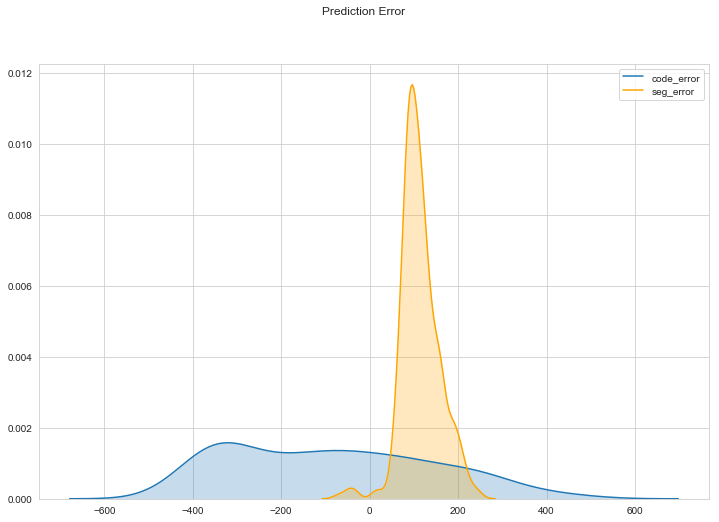

In [47]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axs = plt.subplots(figsize=(12,8))
sns.set_style('whitegrid')
fig.suptitle('Prediction Error')

sns.kdeplot(code_error['code_error'], shade=True);
sns.kdeplot(clust_error['seg_error'], shade=True, color="orange")

# save
fig.savefig(location+'error_dist.png')